In [1]:
import numpy as np
import torch
import random
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd  # added import for pandas

# Import your modules
from model.model import TicTacToeCNN
from src.dataloader import load_dataset
from src.eval import evaluate_agents
from src.train import train_model, train_model_with_early_stopping

In [2]:
def set_seed(seed):
    """Sets the random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # For multi-GPU setups
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def load_mcts_data(data_dir="./monte_carlo_data"):
    """
    Loads pre-generated MCTS data from .npy files.
    Returns a dictionary mapping board state string to MCTS probabilities.
    """
    mcts_data = {}
    print(f"Loading MCTS data from {data_dir}...")
    for filename in tqdm(os.listdir(data_dir)):
        if filename.endswith(".npy"):
            file_path = os.path.join(data_dir, filename)
            data = np.load(file_path, allow_pickle=True)
            board_input = data[0]
            mcts_probs = data[1]

            # Reconstruct the board state string from the input array
            board_list = [' ' for _ in range(9)]
            for i in range(3):
                for j in range(3):
                    idx = i * 3 + j
                    if board_input[0, i, j] == 1:
                        board_list[idx] = 'O'
                    elif board_input[1, i, j] == 1:
                        board_list[idx] = 'X'
            state_key = ''.join(board_list)
            mcts_data[state_key] = mcts_probs
    print(f"Loaded {len(mcts_data)} MCTS states.")
    return mcts_data


def run_curriculum_experiment(seed, preloaded_mcts_data, epochs, optimizer_choice, criterion_choice, default_eval_games, mcts_eval_games):
    """Trains curriculum models and evaluates them against each other, MCTS agent, and random agent."""
    print(f"\n--- Running Curriculum Experiment with seed: {seed} ---")
    set_seed(seed)
    models = {}
    results_summary = {}
    
    for curriculum_type in ["easy_to_hard", "hard_to_easy", "random"]:
        # Train model for given curriculum type
        train_data_loader = load_dataset(curriculum_type)
        model = TicTacToeCNN(kl_div=(criterion_choice == "kl_div"))
        train_model(model, train_data_loader, epochs=epochs, optimizer=optimizer_choice, 
                    criterion=criterion_choice, disable_wandb=True, verbose=False)
        model.eval()
        models[curriculum_type] = model

    # Evaluate comparisons among curriculum models
    curriculum_types = list(models.keys())
    for i in range(len(curriculum_types)):
        for j in range(i + 1, len(curriculum_types)):
            m1 = models[curriculum_types[i]]
            m2 = models[curriculum_types[j]]
            results = evaluate_agents(m1, m2,
                                      games=default_eval_games,
                                      agent1_criterion=criterion_choice,
                                      agent2_criterion=criterion_choice)
            comp_name = f"{curriculum_types[i]} vs {curriculum_types[j]}"
            results_summary[comp_name] = results
            print(f"Results ({comp_name}): {results}")

    # Evaluate each model vs pre-computed MCTS agent
    for curriculum_type, model in models.items():
        results = evaluate_agents(model, 'mcts_data_agent',
                                  games=mcts_eval_games,
                                  agent1_criterion=criterion_choice,
                                  agent2_criterion=None,
                                  mcts_data=preloaded_mcts_data)
        comp_name = f"{curriculum_type} vs MCTS_data_agent"
        results_summary[comp_name] = results
        print(f"Results ({comp_name}): {results}")

    # Evaluate each model vs pure random agent
    for curriculum_type, model in models.items():
        results = evaluate_agents(model, 'random_agent',
                                  games=default_eval_games,
                                  agent1_criterion=criterion_choice,
                                  agent2_criterion=None)
        comp_name = f"{curriculum_type} vs Random_agent"
        results_summary[comp_name] = results
        print(f"Results ({comp_name}): {results}")
    
    return models, results_summary


def run_data_portion_experiment(seed, preloaded_mcts_data, epochs, optimizer_choice, criterion_choice, mcts_eval_games):
    """Trains models on varying portions of data and evaluates against the MCTS agent."""
    print(f"\n--- Running Data Portion Experiment with seed: {seed} ---")
    set_seed(seed)
    data_percentages = [0.1, 0.25, 0.5, 0.75, 1.0]
    data_portion_results = {ct: {p: [] for p in data_percentages} for ct in ["easy_to_hard", "hard_to_easy", "random"]}
    
    for curriculum_type in ["easy_to_hard", "hard_to_easy", "random"]:
        test_data_loader = load_dataset(curriculum_type, split='test', data_percentage=1.0)
        for percentage in data_percentages:
            train_data_loader = load_dataset(curriculum_type, split='train', data_percentage=percentage)
            model = TicTacToeCNN(kl_div=(criterion_choice == "kl_div"))
            train_model_with_early_stopping(model, train_data_loader, test_data_loader,
                                            epochs=epochs, optimizer=optimizer_choice,
                                            criterion=criterion_choice, patience=10,
                                            min_delta=0.0001, disable_wandb=True, verbose=False)
            model.eval()
            results = evaluate_agents(model, 'mcts_data_agent',
                                      games=mcts_eval_games,
                                      agent1_criterion=criterion_choice,
                                      agent2_criterion=None,
                                      mcts_data=preloaded_mcts_data)
            a1_win = results["agent1_wins"]
            a2_win = results["agent2_wins"]
            win_rate = a1_win / (a1_win + a2_win) if (a1_win + a2_win) > 0 else 0
            data_portion_results[curriculum_type][percentage].append(win_rate)
            print(f"Win rate for {curriculum_type} with {percentage*100}% data: {win_rate:.4f}")
    return data_portion_results


def load_base_models(optimizer_choice, criterion_choice, epochs):
    """Trains and returns base models for each curriculum type using a fixed seed."""
    base_seed = 42
    set_seed(base_seed)
    base_models = {}
    for curriculum_type in ["easy_to_hard", "hard_to_easy", "random"]:
        train_data_loader = load_dataset(curriculum_type)
        model = TicTacToeCNN(kl_div=(criterion_choice == "kl_div"))
        train_model(model, train_data_loader, epochs=epochs, optimizer=optimizer_choice, 
                    criterion=criterion_choice, disable_wandb=True, verbose=False)
        model.eval()
        base_models[curriculum_type] = model
    return base_models


def perturb_model_weights(model, strength, criterion_choice):
    """Applies random perturbation to model weights."""
    perturbed_model = TicTacToeCNN(kl_div=(criterion_choice == "kl_div"))
    perturbed_model.load_state_dict(model.state_dict())
    with torch.no_grad():
        for param in perturbed_model.parameters():
            param.add_(torch.randn(param.size()) * strength)
    return perturbed_model


def run_perturbation_experiment(seed, base_models, preloaded_mcts_data, mcts_eval_games, criterion_choice, perturbation_strength):
    """Perturbs each base model and evaluates against the MCTS agent."""
    print(f"\n--- Running Perturbation Experiment with perturbation seed: {seed} ---")
    set_seed(seed)
    perturbation_results = {ct: [] for ct in ["easy_to_hard", "hard_to_easy", "random"]}
    for curriculum_type in ["easy_to_hard", "hard_to_easy", "random"]:
        original_model = base_models[curriculum_type]
        print(f"Perturbing {curriculum_type} model...")
        perturbed_model = perturb_model_weights(original_model, perturbation_strength, criterion_choice)
        results = evaluate_agents(perturbed_model, 'mcts_data_agent',
                                  games=mcts_eval_games,
                                  agent1_criterion=criterion_choice,
                                  agent2_criterion=None,
                                  mcts_data=preloaded_mcts_data)
        a1_win = results["agent1_wins"]
        a2_win = results["agent2_wins"]
        win_rate = a1_win / (a1_win + a2_win) if (a1_win + a2_win) > 0 else 0
        perturbation_results[curriculum_type].append(win_rate)
        print(f"Win rate for perturbed {curriculum_type} model: {win_rate:.4f}")
    return perturbation_results


def plot_data_portion_results(data_portion_results, data_percentages):
    """Plots average win rates with error bars for data portion experiments."""
    for curriculum_type, percentage_data in data_portion_results.items():
        avg_win_rates = []
        std_win_rates = []
        for pct in data_percentages:
            rates = percentage_data[pct]
            avg_win_rates.append(np.mean(rates))
            std_win_rates.append(np.std(rates))
        plt.figure(figsize=(10, 6))
        plt.errorbar(data_percentages, avg_win_rates, yerr=std_win_rates, fmt='-o', capsize=5)
        plt.title(f'Win Rate vs Data Percentage ({curriculum_type})')
        plt.xlabel('Percentage of Data Used for Training')
        plt.ylabel('Average Win Rate')
        plt.ylim(0, 1)
        plt.grid(True)
        plt.show()  # Replace with plt.savefig(...) if saving is needed
        plt.close()

def plot_perturbation_results(perturbation_results, perturbation_strength):
    """Plots bar chart for perturbation experiment results."""
    curriculum_labels = list(perturbation_results.keys())
    avg_win_rates = []
    std_win_rates = []
    for ct in curriculum_labels:
        rates = perturbation_results[ct]
        avg_win_rates.append(np.mean(rates))
        std_win_rates.append(np.std(rates))
    x = np.arange(len(curriculum_labels))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, 6))
    rects = ax.bar(x, avg_win_rates, width, yerr=std_win_rates, capsize=5)
    ax.set_ylabel('Average Win Rate Against MCTS Data Agent')
    ax.set_title(f'Perturbation Win Rate (Strength: {perturbation_strength})')
    ax.set_xticks(x)
    ax.set_xticklabels([ct for ct in curriculum_labels])
    ax.set_ylim(0, 1)
    plt.show()  # Replace with plt.savefig(...) if saving is required
    plt.close()


def plot_perturbation_results_by_strength(multi_results, strengths):
    """Plots grouped bar chart with perturbation strength on X-axis and colored bars for each curriculum."""
    curriculum_types = list(multi_results.keys())
    means_by_curriculum = {}
    stds_by_curriculum = {}
    for curr in curriculum_types:
        means = []
        stds = []
        for s in strengths:
            rates = multi_results[curr][str(s)]
            means.append(np.mean(rates))
            stds.append(np.std(rates))
        means_by_curriculum[curr] = means
        stds_by_curriculum[curr] = stds
    x = np.arange(len(strengths))
    total_width = 0.8
    bar_width = total_width / len(curriculum_types)
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, curr in enumerate(curriculum_types):
        ax.bar(x + i * bar_width, means_by_curriculum[curr], width=bar_width, yerr=stds_by_curriculum[curr], 
               capsize=5, label=curr)
    ax.set_xticks(x + total_width / 2 - bar_width / 2)
    ax.set_xticklabels([str(s) for s in strengths])
    ax.set_xlabel("Perturbation Strength")
    ax.set_ylabel("Average Win Rate Against MCTS Data Agent")
    ax.set_title("Perturbation Win Rates vs Perturbation Strength by Curriculum")
    ax.legend(title="Curriculum")
    ax.set_ylim(0, 1)
    plt.show()


def run_all_curriculum_experiments(seeds, preloaded_mcts_data, epochs, optimizer_choice, criterion_choice, default_eval_games, mcts_eval_games):
    """Runs curriculum experiments for all seeds and aggregates results into a pandas DataFrame.
    Each row represents a matchup between two agents with the seed, agent1 wins, agent2 wins, and draws.
    """
    all_rows = []
    for seed in seeds:
        _, results_summary = run_curriculum_experiment(seed, preloaded_mcts_data, epochs, optimizer_choice, 
                                                       criterion_choice, default_eval_games, mcts_eval_games)
        for matchup, res in results_summary.items():
            row = {
                "seed": seed,
                "matchup": matchup,
                "agent1_wins": res.get("agent1_wins", 0),
                "agent2_wins": res.get("agent2_wins", 0),
                "draws": res.get("draws", 0)
            }
            all_rows.append(row)
    df = pd.DataFrame(all_rows)
    return df

Loading MCTS data from ./monte_carlo_data...


  0%|          | 0/4520 [00:00<?, ?it/s]

100%|██████████| 4520/4520 [00:00<00:00, 17562.85it/s]


Loaded 4520 MCTS states.

--- Running Curriculum Experiment with seed: 42 ---


/home/parkmyungheon/Desktop/Work/CS-439/OptML_TTT/src/eval.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647176074/work/torch/csrc/utils/tensor_new.cpp:278.)
  raw_output = agent(torch.tensor([board], dtype=torch.float32)).squeeze().view(9)


Results (easy_to_hard vs hard_to_easy): {'agent1_wins': 2883, 'agent2_wins': 1327, 'draw': 790}
Results (easy_to_hard vs random): {'agent1_wins': 2972, 'agent2_wins': 1281, 'draw': 747}
Results (hard_to_easy vs random): {'agent1_wins': 2194, 'agent2_wins': 2177, 'draw': 629}
Results (easy_to_hard vs MCTS_data_agent): {'agent1_wins': 2501, 'agent2_wins': 1582, 'draw': 917}
Results (hard_to_easy vs MCTS_data_agent): {'agent1_wins': 1608, 'agent2_wins': 2561, 'draw': 831}
Results (random vs MCTS_data_agent): {'agent1_wins': 1571, 'agent2_wins': 2648, 'draw': 781}
Results (easy_to_hard vs Random_agent): {'agent1_wins': 3265, 'agent2_wins': 1028, 'draw': 707}
Results (hard_to_easy vs Random_agent): {'agent1_wins': 2572, 'agent2_wins': 1810, 'draw': 618}
Results (random vs Random_agent): {'agent1_wins': 2629, 'agent2_wins': 1742, 'draw': 629}

--- Running Curriculum Experiment with seed: 101 ---
Results (easy_to_hard vs hard_to_easy): {'agent1_wins': 2857, 'agent2_wins': 1364, 'draw': 779}
R

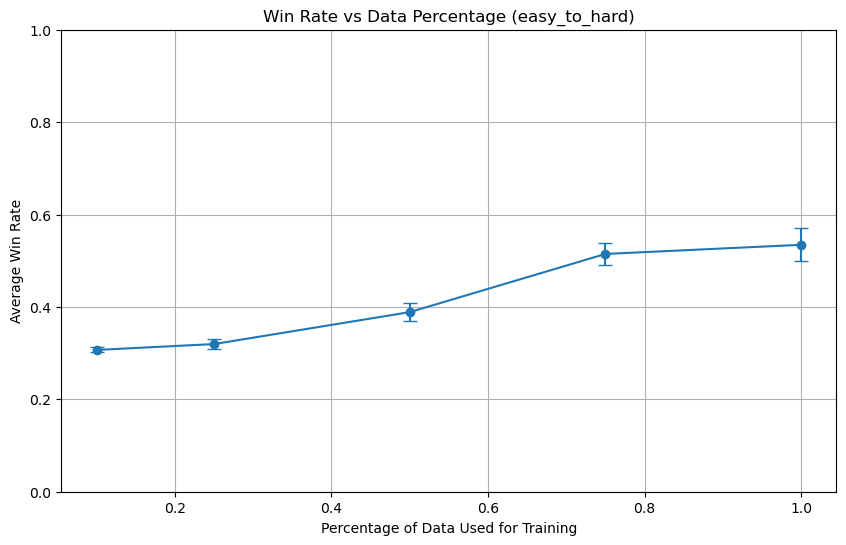

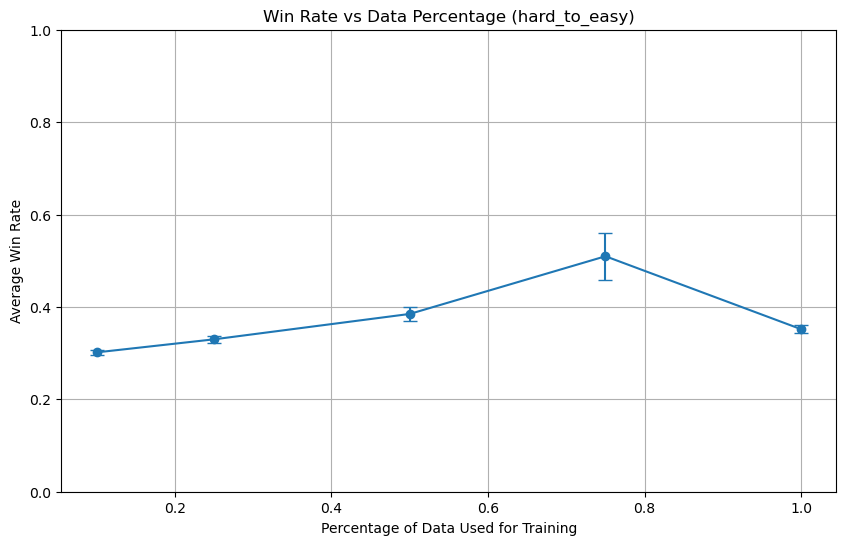

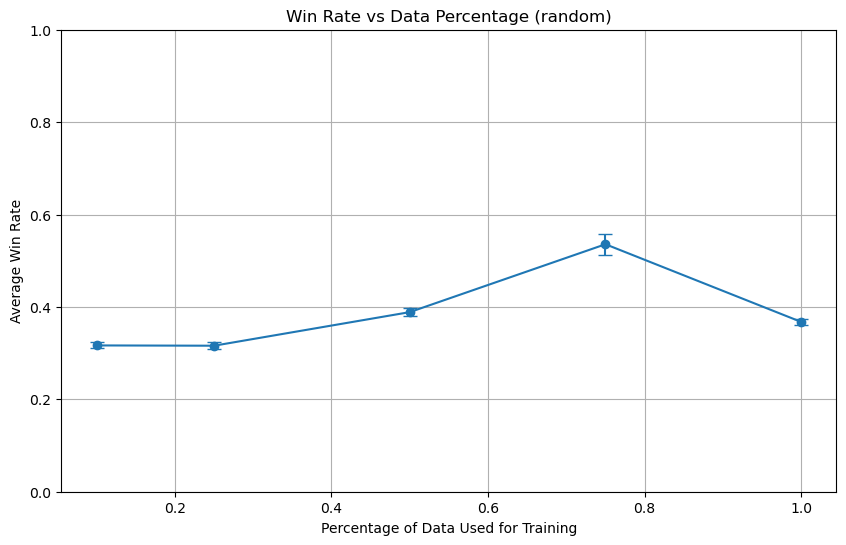

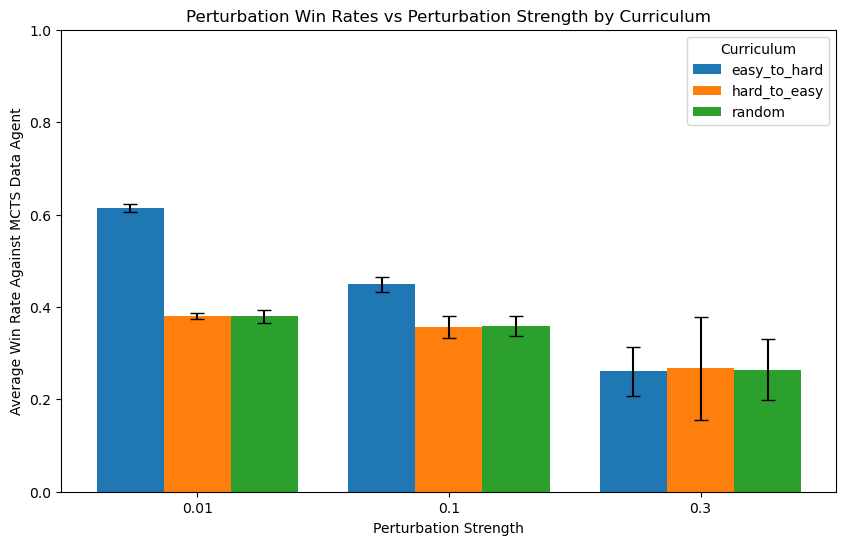

In [3]:
if __name__ == "__main__":
    epochs = 5
    optimizer_choice = "adam"
    criterion_choice = "mse"  # or "kl_div"
    default_eval_games = 5000
    mcts_eval_games = 5000
    seeds = [42, 101, 202, 303, 404]
    data_percentages = [0.1, 0.25, 0.5, 0.75, 1.0]
    
    preloaded_mcts_data = load_mcts_data()
    
    # Run curriculum experiments and collect results into one DataFrame
    curriculum_df = run_all_curriculum_experiments(seeds, preloaded_mcts_data, epochs, optimizer_choice, 
                                                   criterion_choice, default_eval_games, mcts_eval_games)
    print("\nAggregated Curriculum Experiment Results:")
    print(curriculum_df)
    
    # Aggregate results from data portion experiments across seeds
    combined_data_portion_results = {ct: {p: [] for p in data_percentages} for ct in ["easy_to_hard", "hard_to_easy", "random"]}
    for seed in seeds:
        dp_results = run_data_portion_experiment(seed, preloaded_mcts_data, epochs, optimizer_choice, criterion_choice, mcts_eval_games)
        for ct in combined_data_portion_results:
            for p in data_percentages:
                combined_data_portion_results[ct][p].extend(dp_results[ct][p])
    
    # Aggregate results from perturbation experiments across seeds for multiple strengths
    perturbation_strengths = [0.01, 0.1, 0.3]
    combined_perturbation_results = {ct: {str(s): [] for s in perturbation_strengths} for ct in ["easy_to_hard", "hard_to_easy", "random"]}
    base_models = load_base_models(optimizer_choice, criterion_choice, epochs)
    for strength in perturbation_strengths:
        for seed in seeds:
            p_results = run_perturbation_experiment(seed, base_models, preloaded_mcts_data, mcts_eval_games, criterion_choice, strength)
            for ct in combined_perturbation_results:
                combined_perturbation_results[ct][str(strength)].extend(p_results[ct])
    
    # Plot results for data portion and perturbation experiments
    plot_data_portion_results(combined_data_portion_results, data_percentages)
    plot_perturbation_results_by_strength(combined_perturbation_results, perturbation_strengths)